In [22]:
%matplotlib inline
from IPython import display
import os
import io
import itertools
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import importlib

import rtmtools.lblrtm.aerutils as aerutils
import rtmtools.lblrtm.aeranalyse as aeranalyse
import rtmtools.lblrtm.visualisation as viz

import rtmtools.clirad.sw.wrangle as cliradwrangle
import rtmtools.clirad.sw.analyse as cliradanalyse
import rtmtools.clirad.lw.info

import rtmtools.rrtmg.lw.wrangle as rrtmgwrangle
import rtmtools.rrtmg.sw.analyse as rrtmganalyse



importlib.reload(aerutils)
importlib.reload(aeranalyse)
importlib.reload(viz)

importlib.reload(cliradwrangle)
importlib.reload(cliradanalyse)
importlib.reload(rtmtools.clirad.lw.info)

importlib.reload(rrtmgwrangle)
importlib.reload(rrtmganalyse)

<module 'rtmtools.rrtmg.sw.analyse' from '/nuwa_cluster/home/jackyu/radiation/rtmtools/rtmtools/rrtmg/sw/analyse.py'>

In [20]:
name_molecule = r'$CO_{2}$'

#### Load CRD results

In [3]:
# Get lbl line-by-line results
pathout_crd = '/nuwa_cluster/home/jackyu/radiation/crd_compute/LW/lbl_H2008_CO2_cut25/OUTPUT_RADSUM'
pnl_crd = aerutils.OUTPUT_RADSUM_to_pandasPanel(readfrom = pathout_crd, cooling_rate = True, signed_fluxes = True)


In [13]:
# H1996 cutoff = 10 cm-1
pathout_crd1 = '/nuwa_cluster/home/jackyu/radiation/crd/LW/examples/lbl_H1996_CO2_cut10/OUTPUT_RADSUM'
pnl_crd1 = aerutils.OUTPUT_RADSUM_to_pandasPanel(readfrom = pathout_crd1, cooling_rate = True, signed_fluxes = True)


#### Load CLIRAD results

In [25]:
# Read OUTPUT_CLIRAD.dat
pathout_clirad = '/nuwa_cluster/home/jackyu/radiation/clirad/LW/examples/mls75_CO2_H2012/OUTPUT_CLIRAD.dat'
pnl_clirad = cliradwrangle.OUTPUT_CLIRAD_to_PandasPanel(readfrom = pathout_clirad, cooling_rate = True, signed_fluxes= True)


In [15]:
# prepare results Hitran 2012 updated version
def path_cliradlw_h2012():
    return '../clirad/LW/examples/mls75_CO2_H2012/CLIRAD_IR_output.dat'


def get_rateT(df, ratename = 'cooling rates'):
    return pd.DataFrame({'pressure': .5 * (df['p'].values[1:] + df['p'].values[: -1]),
                    ratename: df[ratename].values[1:]})


df = cliradwrangle.output_txtfile_to_DataFrame(path_cliradlw_h2012())

rateT_clirad2012 = get_rateT(df, ratename = 'cooling rates')

#### Load LBLRTM results

In [5]:
# Get AER line-by-line results
pathout_lblrtm = '/nuwa_cluster/home/jackyu/line_by_line/aerlbl_v12.2_package/runs/LW/run_mls75pro_CO2/OUTPUT_RADSUM'
pnl_lblrtm = aerutils.OUTPUT_RADSUM_to_pandasPanel(readfrom = pathout_lblrtm, signed_fluxes = True, cooling_rate = True)



#### Load RRTMG results

In [6]:
pathout_rrtmg = '/nuwa_cluster/home/jackyu/radiation/rrtmg/LW/examples/mls70_CO2/OUTPUT_RRTM'
pnl_rrtmg = rrtmgwrangle.OUTPUT_RRTM_to_pandasPanel(readfrom = pathout_rrtmg, signed_fluxes = True, cooling_rate = True)



In [31]:
pnl_rrtmg[pnl_rrtmg.items[0]].columns

Index(['pressure', 'flux_up', 'flux_down', 'net_flux', 'cooling_rate'], dtype='object')

# Total cooling rates

In [38]:
def plot_total_cooling_rates(infos_wavenumber = None, infos_spectralband = None):
    global molecule_name, xlim_linear
    
    atm_levels = [70, 30, 0]
    
    names_wavenumber, colours_wavenumber, linestyles_wavenumber, pnls_wavenumber = \
    map(list, zip(*infos_wavenumber))
    
    dfs_wavenumber = [aeranalyse.sum_OUTPUT_RADSUM_over_wbands(pnl, V1 = 0, V2 = 3000) \
                      for pnl in pnls_wavenumber]
    
    names_spectralband, colours_spectralband, linestyles_spectralband, pnls_spectralband = \
    map(list, zip(*infos_spectralband))
    
    dfs_spectralband = [cliradanalyse.sum_OUTPUT_CLIRAD_over_wbands(pnl, wbands = range(1, 11))\
                       for pnl in pnls_spectralband]

    dfs = dfs_wavenumber + dfs_spectralband
    names = names_wavenumber + names_spectralband
    colours = colours_wavenumber + colours_spectralband
    linestyles = linestyles_wavenumber + linestyles_spectralband    
    
    dfs_atm_levels = [df.loc[atm_levels, :] for df in dfs]
    
    viz.tabulate_difference(dfs = dfs_atm_levels, 
                            names = names,
                            title = 'Total cooling rate. {}'.format(name_molecule))    
    
    
    max_cr = max([df['cooling_rate'].max() for df in dfs])
    
    viz.plot_pres_vs_hrcr(dfs = dfs,
                          names = names,
                          linestyles = linestyles, 
                          colours = colours,
                          title = 'Total cooling rate. {}'.format(name_molecule),
                          cooling_rate = True,
                          xlim_linear = xlim_linear,
                          xlim_log = (- .1, 20) if max_cr >= 20 else None)
    
    display.display(plt.gcf()); plt.close()
    


Total cooling rate. $CO_{2}$

CRD
       pressure     flux_up  flux_down    net_flux  cooling_rate
70     0.002417 -383.273276   0.000000 -383.273276      0.000000
30   299.800000 -389.763984  21.277476 -368.486508      0.155939
0   1013.000000 -423.662018  77.656605 -346.005414      0.364312

LBLRTM
     pressure     flux_up  flux_down    net_flux  cooling_rate
70     0.0024 -383.100650   0.000000 -383.100650      0.000000
30   299.8000 -389.784564  21.088600 -368.695964      0.146416
0   1013.0000 -423.532488  77.113869 -346.418619      0.352086

RRTMG
      pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -382.5392     0.0000 -382.5392       0.00000
30   299.70000 -389.3473    21.3458 -368.0015       0.14629
0   1013.00000 -423.5988    78.3065 -345.2923       0.39335

CLIRAD
       pressure     flux_up  flux_down    net_flux  cooling_rate
70     0.002417 -385.553564   0.020013 -385.533551      7.980369
30   299.800000 -391.640304  20.897889 -370.742415      0.15

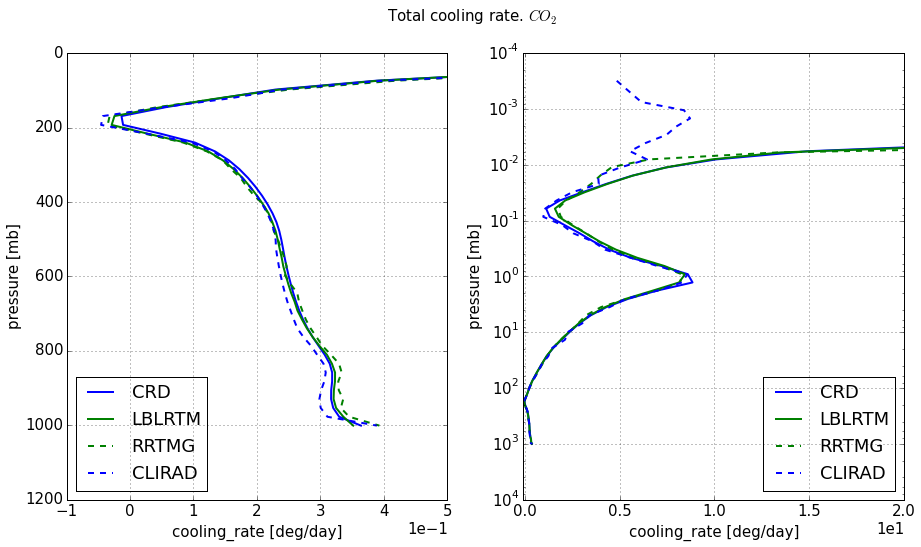

In [39]:
xlim_linear = (- .1, .5)
plot_total_cooling_rates(infos_wavenumber = [('CRD', 'b', '-', pnl_crd),\
                                            ('LBLRTM', 'g', '-', pnl_lblrtm),\
                                            ('RRTMG', 'g', '--', pnl_rrtmg)],
                        infos_spectralband = [('CLIRAD', 'b', '--', pnl_clirad)])

In [37]:
xlim_linear = (- .1, .2)

# In RRTMG's wavenumber bands

In [42]:

def fluxtableNhrplot_by_rrtmg_bands(pnl_rrtmg, *infos_lbl):
    global name_molecule
    
    atm_levels = [70, 30, 0]
    
    names, colours, linestyles, pnls_lbl = map(list, zip(*infos_lbl))
        
    lbl_pnls_by_rrtmg_bands = [aeranalyse.lines2bands(pnl_lbl, wbands = pnl_rrtmg.items.values)\
                              for pnl_lbl in pnls_lbl]
 
    names.append('RRTMG')
    colours.append('g')
    linestyles.append('--')
    pnls = [pnl_rrtmg] + lbl_pnls_by_rrtmg_bands
    
    
    for item in pnl_rrtmg.items:
        print('---------------------------------------------------------------------------')
        print() 
        dfs = [pnl[item].loc[atm_levels, :] for pnl in pnls]
        
        viz.tabulate_difference(dfs = dfs, 
                                names = names,
                                title = 'RRTMG Wavenumber band: {} ~ {} cm-1'.format(*item))   
        
        dfs = [pnl[item] for pnl in pnls]
        
        max_cr = max([df['cooling_rate'].max() for df in dfs])
        
        viz.plot_pres_vs_hrcr(dfs = dfs,
                              names = names,
                              linestyles = linestyles, 
                              colours = colours,
                              title = 'Cooling rate {} {} ~ {} cm-1'.format(name_molecule, *item),
                              cooling_rate = True,\
                             xlim_linear = xlim_linear,
                             xlim_log = (-.5, 20) if max_cr >= 20 else None)
    
        display.display(plt.gcf()); plt.close()
    


Flux tables and cooling rates in RRTMG spectral bands


---------------------------------------------------------------------------


RRTMG Wavenumber band: 10.0 ~ 350.0 cm-1

CRD
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -54.5825          0  -54.5825            -0
30   299.70000 -54.5825          0  -54.5825            -0
0   1013.00000 -54.5825          0  -54.5825            -0

LBLRTM
       pressure    flux_up     flux_down   net_flux  cooling_rate
70     0.002417 -54.573788  0.000000e+00 -54.573788  0.000000e+00
30   299.800000 -54.573788  2.932884e-07 -54.573787  1.572515e-09
0   1013.000000 -54.573788  6.174024e-07 -54.573787  4.363773e-09

RRTMG
     pressure    flux_up     flux_down   net_flux  cooling_rate
70     0.0024 -54.662493  0.000000e+00 -54.662493  0.000000e+00
30   299.8000 -54.662493  1.133169e-08 -54.662493  2.601352e-10
0   1013.0000 -54.581667  6.027854e-08 -54.581667  2.868963e-02

CRD - LBLRTM
    pressure   flux_up     flux_dow

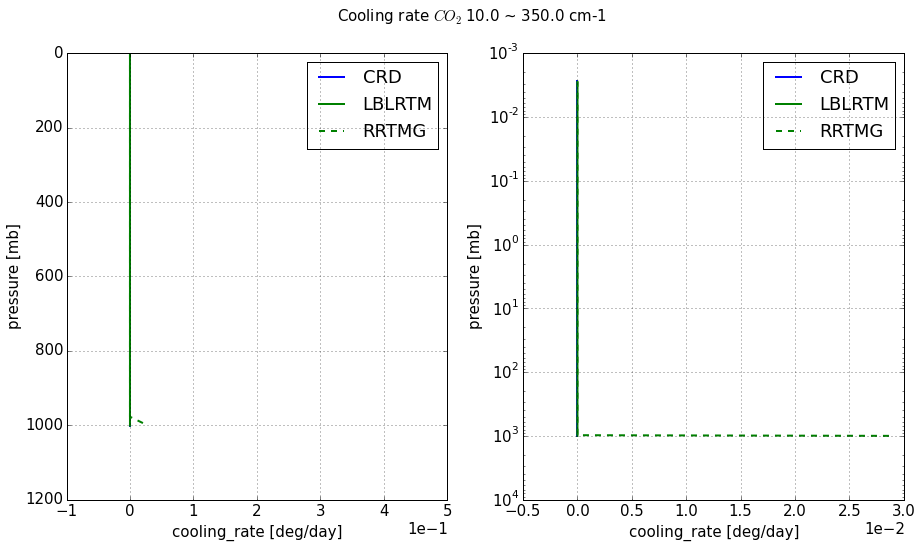

---------------------------------------------------------------------------


RRTMG Wavenumber band: 350.0 ~ 500.0 cm-1

CRD
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -60.9174          0  -60.9174            -0
30   299.70000 -60.9174          0  -60.9174            -0
0   1013.00000 -60.9174          0  -60.9174            -0

LBLRTM
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -60.916037   0.000000 -60.916037  0.000000e+00
30   299.800000 -60.916124   0.000088 -60.916036  6.718444e-07
0   1013.000000 -60.916638   0.004098 -60.912539  9.973436e-05

RRTMG
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -60.928294   0.000000 -60.928294  0.000000e+00
30   299.8000 -60.928382   0.000088 -60.928294  6.721261e-07
0   1013.0000 -60.917465   0.004240 -60.913225  4.166610e-03

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000003 -0.001363   0.000000 -0.001363 -0.000000e+0

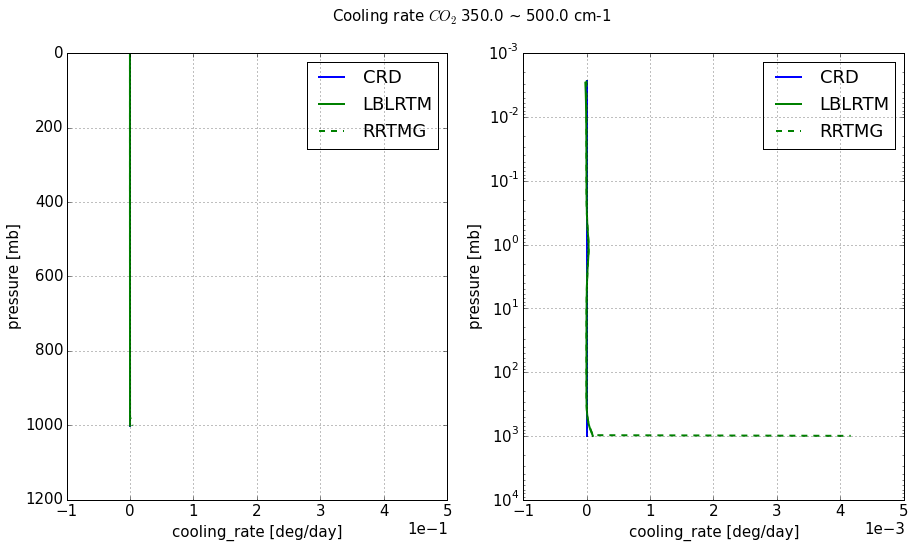

---------------------------------------------------------------------------


RRTMG Wavenumber band: 500.0 ~ 630.0 cm-1

CRD
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -50.5085     0.0000  -50.5085      -0.00000
30   299.70000 -52.2550     3.7925  -48.4625       0.06232
0   1013.00000 -58.6466    20.2704  -38.3762       0.14667

LBLRTM
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -50.013538   0.000000 -50.013538      0.000000
30   299.800000 -51.778173   3.688252 -48.089921      0.060808
0   1013.000000 -58.652387  20.651726 -38.000661      0.146138

RRTMG
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -50.089815   0.000000 -50.089815      0.000000
30   299.8000 -51.879163   3.664142 -48.215022      0.057074
0   1013.0000 -58.646623  20.398981 -38.247643      0.147339

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000003 -0.494962   0.000000 -0.494962     -0.00000

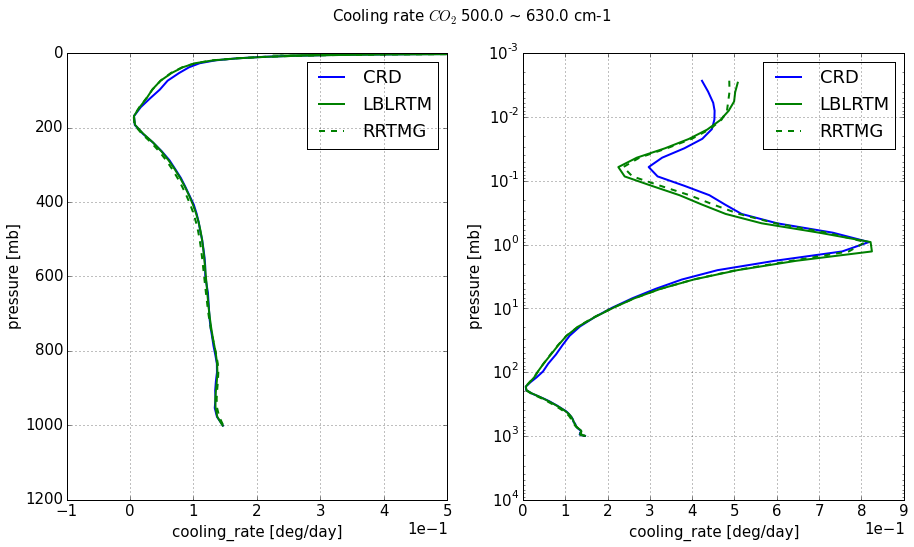

---------------------------------------------------------------------------


RRTMG Wavenumber band: 630.0 ~ 700.0 cm-1

CRD
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -11.9206     0.0000  -11.9206      -0.00000
30   299.70000 -14.5137    13.5131   -1.0006       0.04246
0   1013.00000 -30.8956    30.8437   -0.0519       0.01923

LBLRTM
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -12.094168   0.000000 -12.094168      0.000000
30   299.800000 -14.490814  13.462047  -1.028767      0.044383
0   1013.000000 -30.901144  30.860796  -0.040348      0.012921

RRTMG
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -12.024680   0.000000 -12.024680      0.000000
30   299.8000 -14.566414  13.371418  -1.194996      0.042751
0   1013.0000 -30.895458  30.823546  -0.071911      0.015444

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000003  0.173568   0.000000  0.173568     -0.00000

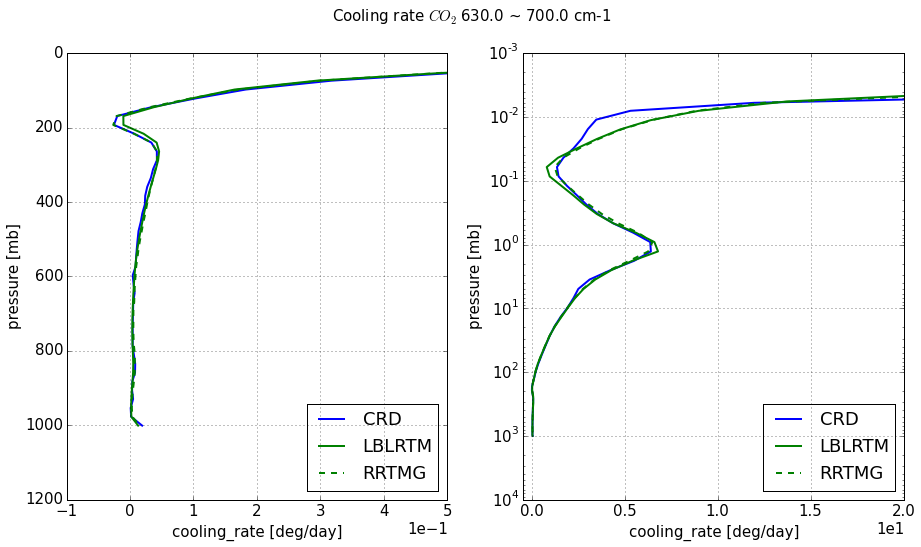

---------------------------------------------------------------------------


RRTMG Wavenumber band: 700.0 ~ 820.0 cm-1

CRD
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -37.0499     0.0000  -37.0499      -0.00000
30   299.70000 -39.2274     3.9085  -35.3189       0.05061
0   1013.00000 -48.8871    23.7295  -25.1576       0.16952

LBLRTM
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -37.572063   0.000000 -37.572063      0.000000
30   299.800000 -39.674031   4.024062 -35.649969      0.057152
0   1013.000000 -48.899846  23.285903 -25.613942      0.155854

RRTMG
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -37.739301   0.000000 -37.739301      0.000000
30   299.8000 -39.854528   3.940537 -35.913991      0.053080
0   1013.0000 -48.886744  22.864324 -26.022420      0.154689

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000003  0.522163   0.000000  0.522163     -0.00000

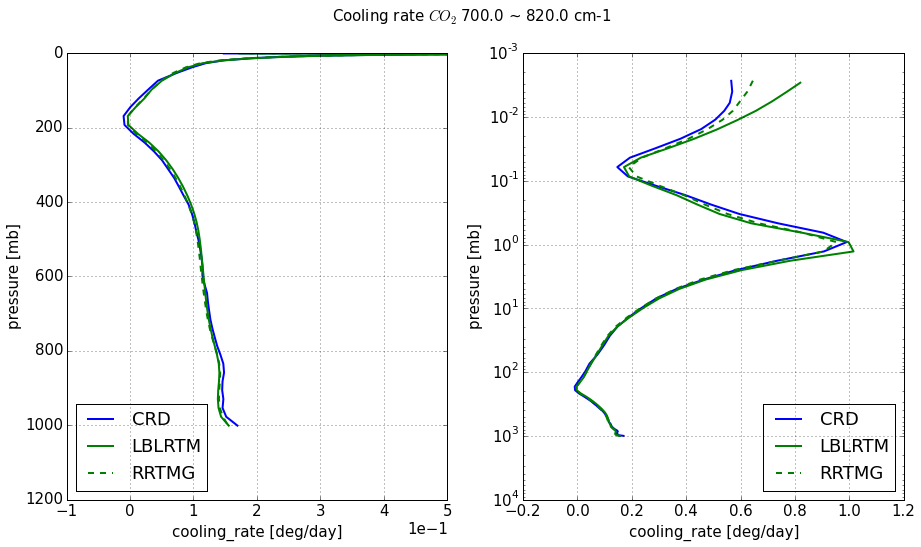

---------------------------------------------------------------------------


RRTMG Wavenumber band: 820.0 ~ 980.0 cm-1

CRD
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -53.6469     0.0000  -53.6469      -0.00000
30   299.70000 -53.7136     0.0234  -53.6902      -0.00157
0   1013.00000 -53.9607     0.9552  -53.0055       0.02181

LBLRTM
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -53.700735   0.000000 -53.700735      0.000000
30   299.800000 -53.754410   0.023077 -53.731332     -0.001126
0   1013.000000 -53.981634   0.814348 -53.167285      0.017664

RRTMG
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -53.666749   0.000000 -53.666749      0.000000
30   299.8000 -53.719835   0.022087 -53.697748     -0.001120
0   1013.0000 -53.960338   0.782696 -53.177642      0.008939

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000003  0.053835   0.000000  0.053835     -0.00000

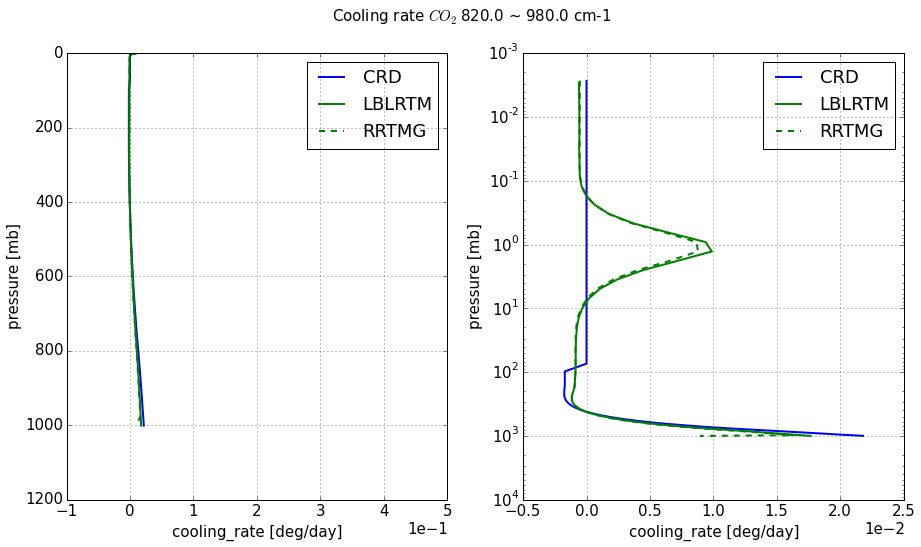

---------------------------------------------------------------------------


RRTMG Wavenumber band: 980.0 ~ 1080.0 cm-1

CRD
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -26.2384     0.0000  -26.2384      -0.00000
30   299.70000 -26.3484     0.0353  -26.3131      -0.00218
0   1013.00000 -26.6401     0.9389  -25.7012       0.02001

LBLRTM
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -26.304439   0.000000 -26.304439      0.000000
30   299.800000 -26.370653   0.025184 -26.345469     -0.001606
0   1013.000000 -26.654056   0.880085 -25.773972      0.018657

RRTMG
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -26.290021   0.000000 -26.290021      0.000000
30   299.8000 -26.355982   0.024205 -26.331776     -0.001603
0   1013.0000 -26.640246   0.850691 -25.789554      0.014198

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000003  0.066039   0.000000  0.066039     -0.0000

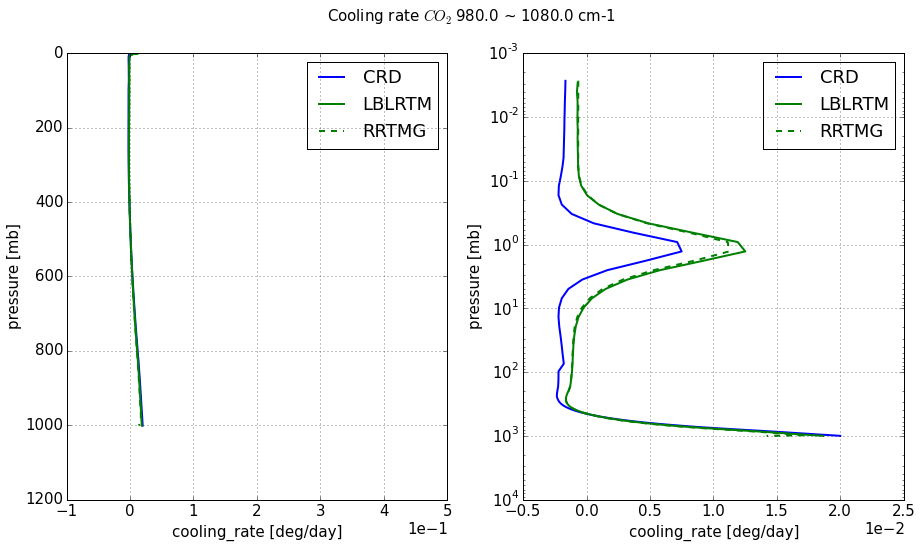

---------------------------------------------------------------------------


RRTMG Wavenumber band: 1080.0 ~ 1180.0 cm-1

CRD
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -21.4454     0.0000  -21.4454      -0.00000
30   299.70000 -21.4641     0.0050  -21.4591      -0.00048
0   1013.00000 -21.5225     0.1826  -21.3399       0.00441

LBLRTM
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -21.465427   0.000000 -21.465427      0.000000
30   299.800000 -21.476758   0.004027 -21.472731     -0.000305
0   1013.000000 -21.535940   0.192343 -21.343597      0.004442

RRTMG
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -21.448097   0.000000 -21.448097      0.000000
30   299.8000 -21.459109   0.003766 -21.455343     -0.000295
0   1013.0000 -21.522739   0.178986 -21.343752      0.001087

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000003  0.020027   0.000000  0.020027     -0.000

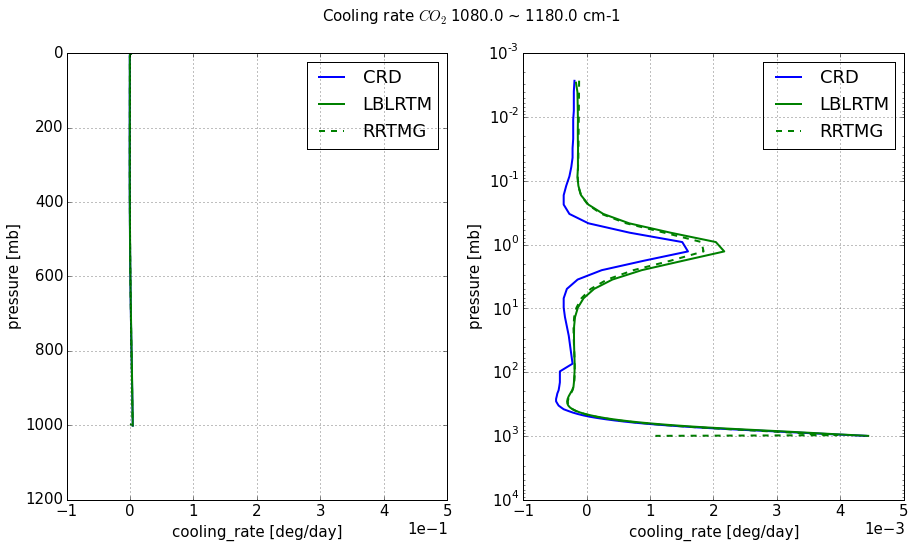

---------------------------------------------------------------------------


RRTMG Wavenumber band: 1180.0 ~ 1390.0 cm-1

CRD
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -31.2994          0  -31.2994            -0
30   299.70000 -31.2994          0  -31.2994            -0
0   1013.00000 -31.2994          0  -31.2994            -0

LBLRTM
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -31.247130   0.000000 -31.247130      0.000000
30   299.800000 -31.284525   0.006237 -31.278288     -0.000731
0   1013.000000 -31.323236   0.073322 -31.249914      0.001210

RRTMG
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -31.213357   0.000000 -31.213357      0.000000
30   299.8000 -31.250103   0.006031 -31.244072     -0.000709
0   1013.0000 -31.299603   0.070968 -31.228635     -0.003131

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000003 -0.052270   0.000000 -0.052270     -0.000

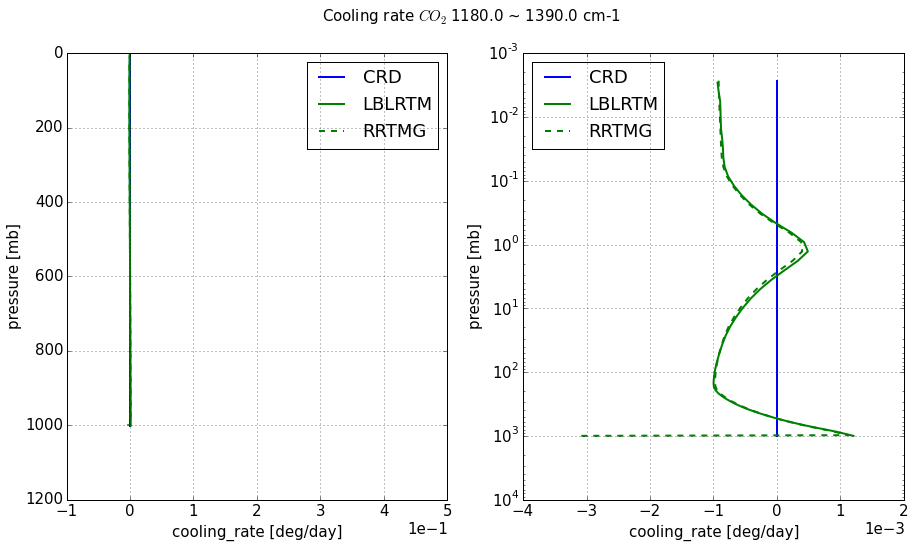

---------------------------------------------------------------------------


RRTMG Wavenumber band: 1390.0 ~ 1480.0 cm-1

CRD
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -8.8986          0   -8.8986            -0
30   299.70000  -8.8986          0   -8.8986            -0
0   1013.00000  -8.8986          0   -8.8986            -0

LBLRTM
       pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.002417 -8.903635   0.000000 -8.903635      0.000000
30   299.800000 -8.904803   0.000173 -8.904630     -0.000027
0   1013.000000 -8.906562   0.003409 -8.903153      0.000067

RRTMG
     pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.0024 -8.891755   0.000000 -8.891755      0.000000
30   299.8000 -8.892931   0.000173 -8.892758     -0.000027
0   1013.0000 -8.898490   0.003467 -8.895022     -0.001273

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000003  0.005035   0.000000  0.005035     -0.000000
30 -0.100000

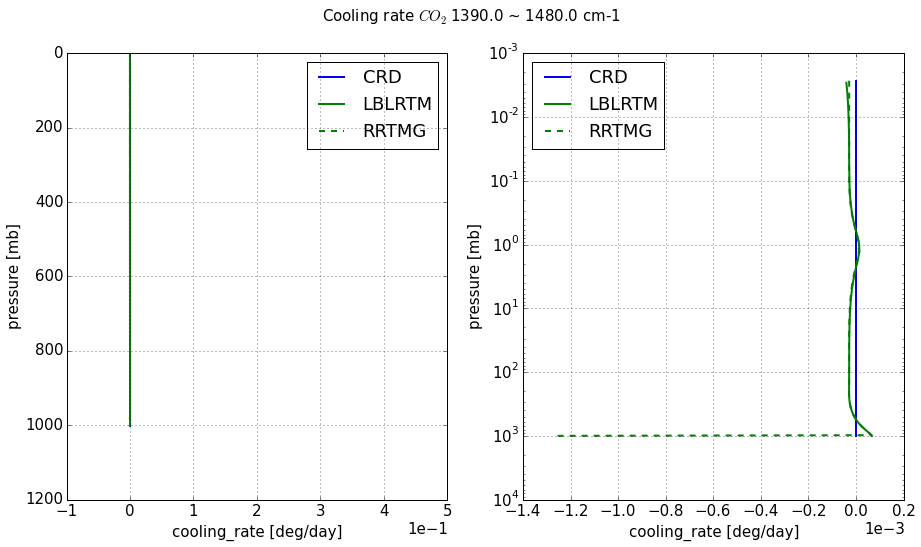

---------------------------------------------------------------------------


RRTMG Wavenumber band: 1480.0 ~ 1800.0 cm-1

CRD
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -17.8828          0  -17.8828            -0
30   299.70000 -17.8828          0  -17.8828            -0
0   1013.00000 -17.8828          0  -17.8828            -0

LBLRTM
       pressure    flux_up     flux_down   net_flux  cooling_rate
70     0.002417 -17.902258  0.000000e+00 -17.902258  0.000000e+00
30   299.800000 -17.902258  2.293236e-08 -17.902258 -9.065695e-10
0   1013.000000 -17.902258  9.652420e-08 -17.902258  1.635737e-09

RRTMG
     pressure    flux_up     flux_down   net_flux  cooling_rate
70     0.0024 -17.873994  0.000000e+00 -17.873994  0.000000e+00
30   299.8000 -17.873995  8.729626e-08 -17.873995 -2.659371e-08
0   1013.0000 -17.882889  1.134969e-05 -17.882877 -3.154926e-03

CRD - LBLRTM
    pressure   flux_up     flux_down  net_flux  cooling_rate
70  0.000003  0.019458  0.0

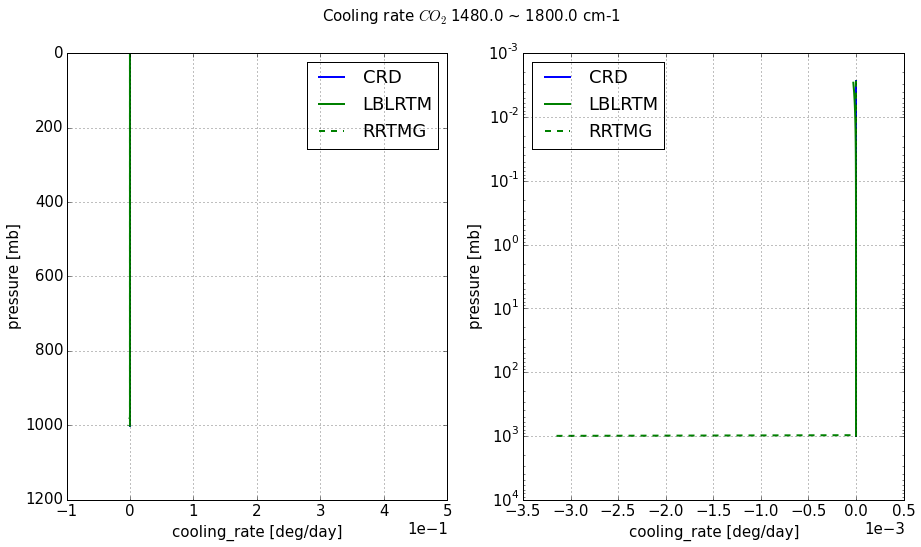

---------------------------------------------------------------------------


RRTMG Wavenumber band: 1800.0 ~ 2080.0 cm-1

CRD
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -5.7512     0.0000   -5.7512      -0.00000
30   299.70000  -5.7979     0.0060   -5.7919      -0.00187
0   1013.00000  -5.9578     0.2047   -5.7531       0.00384

LBLRTM
       pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.002417 -5.748949   0.000000 -5.748949      0.000000
30   299.800000 -5.798119   0.006325 -5.791794     -0.001787
0   1013.000000 -5.965987   0.211806 -5.754180      0.004055

RRTMG
     pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.0024 -5.683672   0.000000 -5.683672      0.000000
30   299.8000 -5.733237   0.006116 -5.727120     -0.001784
0   1013.0000 -5.957771   0.203226 -5.754545     -0.018190

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000003 -0.002251   0.000000 -0.002251     -0.000000
30 -0.100000

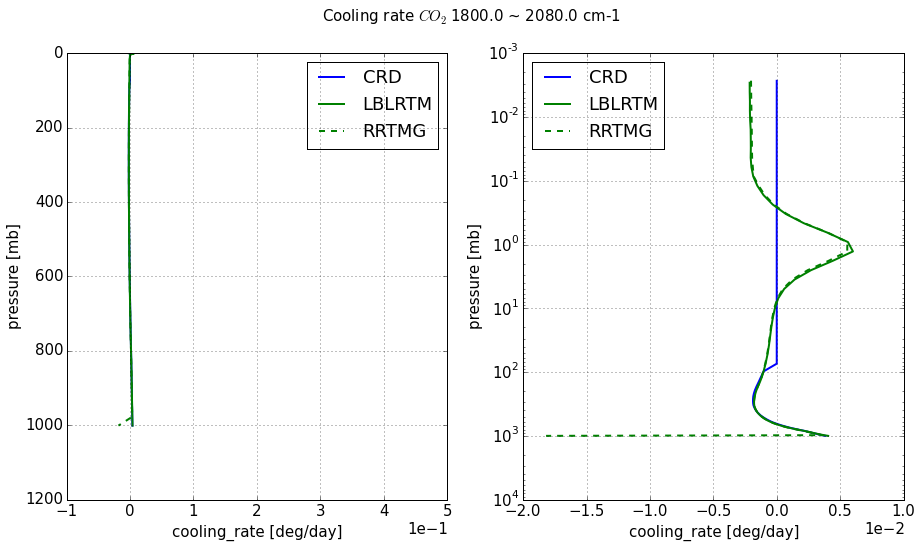

---------------------------------------------------------------------------


RRTMG Wavenumber band: 2080.0 ~ 2250.0 cm-1

CRD
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -1.3537     0.0000   -1.3537      -0.00000
30   299.70000  -1.4036     0.0070   -1.3966      -0.00192
0   1013.00000  -1.6390     0.2811   -1.3579       0.00457

LBLRTM
       pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.002417 -1.590261   0.000000 -1.590261      0.000000
30   299.800000 -1.602115   0.000924 -1.601191     -0.000437
0   1013.000000 -1.641655   0.053801 -1.587854      0.001306

RRTMG
     pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.0024 -1.474235   0.000000 -1.474235      0.000000
30   299.8000 -1.496126   0.003815 -1.492312     -0.000836
0   1013.0000 -1.639014   0.183644 -1.455370      0.002800

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000003  0.236561   0.000000  0.236561     -0.000000
30 -0.100000

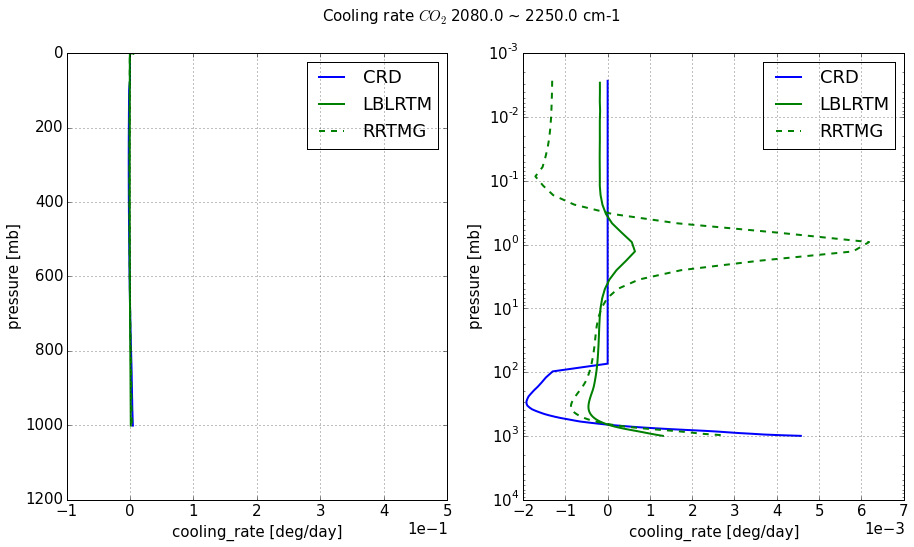

---------------------------------------------------------------------------


RRTMG Wavenumber band: 2250.0 ~ 2380.0 cm-1

CRD
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -0.0762     0.0000   -0.0762      -0.00000
30   299.70000  -0.0517     0.0513   -0.0004      -0.00001
0   1013.00000  -0.7316     0.7314   -0.0002       0.00008

LBLRTM
       pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.002417 -0.236160   0.000000 -0.236160      0.000000
30   299.800000 -0.227483   0.034871 -0.192612     -0.000209
0   1013.000000 -0.732844   0.549390 -0.183454      0.001169

RRTMG
     pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.0024 -0.060062   0.000000 -0.060062      0.000000
30   299.8000 -0.061773   0.045019 -0.016754     -0.000339
0   1013.0000 -0.731556   0.724662 -0.006894      0.001244

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000003  0.159960   0.000000  0.159960     -0.000000
30 -0.100000

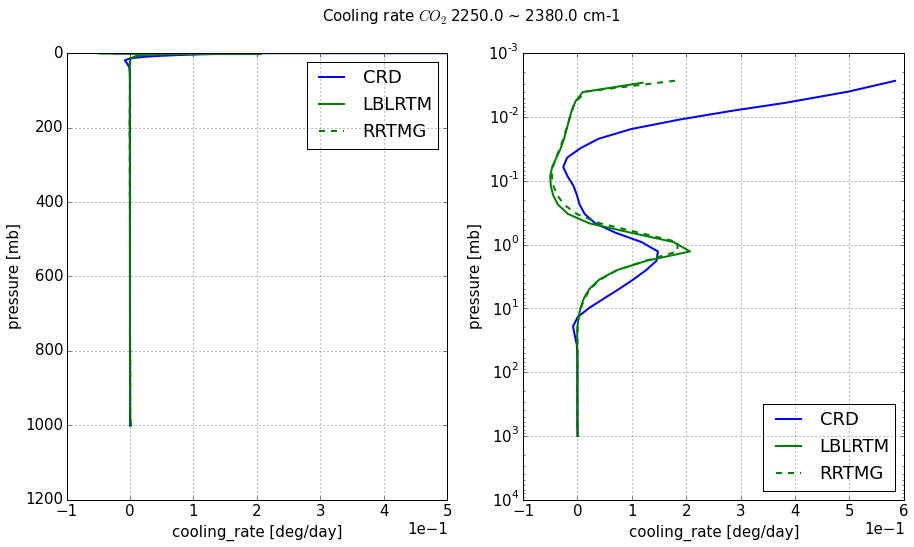

---------------------------------------------------------------------------


RRTMG Wavenumber band: 2380.0 ~ 2600.0 cm-1

CRD
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -0.4964     0.0000   -0.4964      -0.00000
30   299.70000  -0.5199     0.0037   -0.5162      -0.00107
0   1013.00000  -0.6658     0.1690   -0.4968       0.00321

LBLRTM
       pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.002417 -0.598168   0.000000 -0.598168      0.000000
30   299.800000 -0.603234   0.002204 -0.601029     -0.000171
0   1013.000000 -0.667119   0.075381 -0.591739      0.000725

RRTMG
     pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.0024 -0.649414   0.000000 -0.649414      0.000000
30   299.8000 -0.645613   0.001198 -0.644415      0.000228
0   1013.0000 -0.665840   0.024235 -0.641604     -0.000431

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000003  0.101768   0.000000  0.101768     -0.000000
30 -0.100000

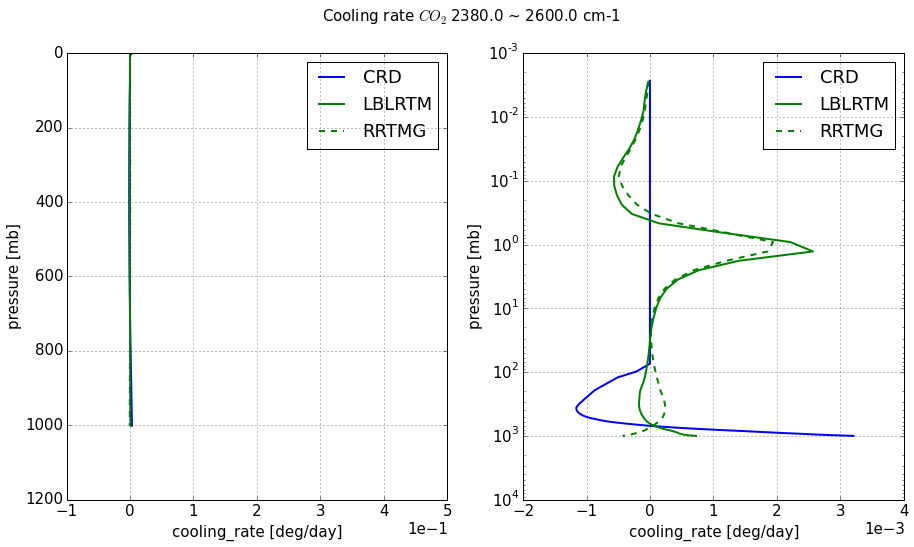

---------------------------------------------------------------------------


RRTMG Wavenumber band: 2600.0 ~ 3250.0 cm-1

CRD
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -0.4713          0   -0.4713            -0
30   299.70000  -0.4713          0   -0.4713            -0
0   1013.00000  -0.4713          0   -0.4713            -0

LBLRTM
       pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.002417 -0.404025   0.000000 -0.404025      0.000000
30   299.800000 -0.404201   0.000004 -0.404197     -0.000005
0   1013.000000 -0.404431   0.000195 -0.404236      0.000005

RRTMG
     pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.0024 -0.402034   0.000000 -0.402034      0.000000
30   299.8000 -0.402204   0.000004 -0.402201     -0.000005
0   1013.0000 -0.403547   0.000191 -0.403356     -0.000393

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000003 -0.067275   0.000000 -0.067275     -0.000000
30 -0.100000

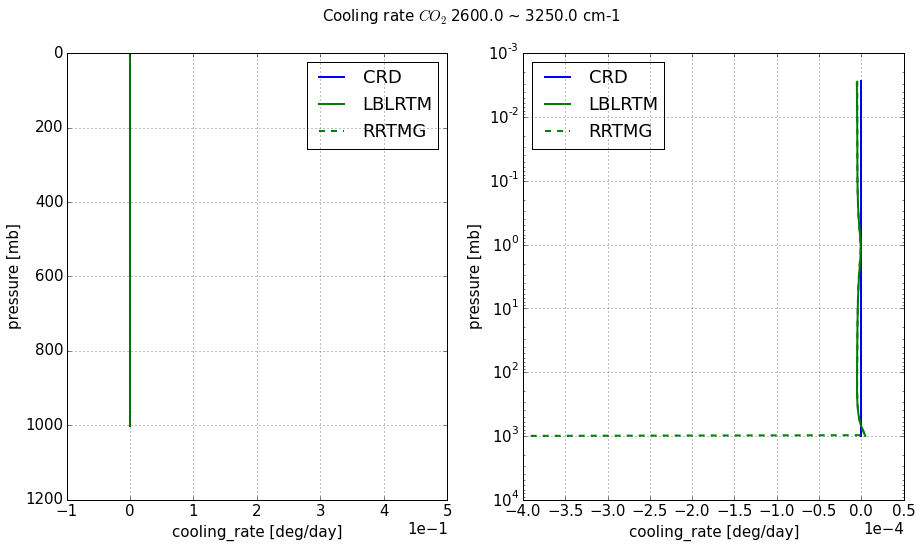

In [43]:
print('Flux tables and cooling rates in RRTMG spectral bands')
print()
print()

fluxtableNhrplot_by_rrtmg_bands(pnl_rrtmg, \
                                ('CRD', 'b', '-', pnl_crd), \
                               ('LBLRTM', 'g', '-', pnl_lblrtm))   

# In CLIRAD's wavenumber bands

In [46]:


def fluxtableNhrplot_by_clirad_bands(pnl_clirad, *infos_lbl):    
    global name_molecule, xlim_linear
    clirad_wbands = rtmtools.clirad.lw.info.wavenumber_bands()
    wbands = list(range(1, 10 + 1))
    wranges = {wband: clirad_wbands[wband] for wband in wbands}
    
    atm_levels = [70, 30, 0]
    
    names, colours, linestyles, pnls_lbl = map(list, zip(*infos_lbl))
           
    lbl_pnls_by_clirad_bands = [rtmtools.clirad.sw.analyse.lines2bands(pnl_lbl, wbands = wranges)\
                              for pnl_lbl in pnls_lbl]

    names.append('CLIRAD')
    colours.append('b')
    linestyles.append('--')
    pnls = [pnl_clirad] + lbl_pnls_by_clirad_bands
    
    for wband in wbands:
        print('---------------------------------------------------------------------------')
        print() 
        dfs = [pnl[wband].loc[atm_levels, :] for pnl in pnls]
        
        wlabel = ' '.join(['{} ~ {}'.format(*interval) for interval in wranges[wband]]) + ' cm-1'
        
        viz.tabulate_difference(dfs = dfs, 
                                names = names,
                                title = 'Wavenumber band: {}, {}'.format(wband, wlabel))
        
        dfs = [pnl[wband] for pnl in pnls]
        
        max_cr = max([df['cooling_rate'].max() for df in dfs])
        
        viz.plot_pres_vs_hrcr(dfs = dfs,
                              names = names,
                              linestyles = linestyles, 
                              colours = colours,
                              title = 'Cooling rate {} {}'.format(name_molecule, wlabel),
                              cooling_rate = True,\
                             xlim_linear = xlim_linear,
                             xlim_log = (-.5, 20) if max_cr >= 20 else None)
    
        display.display(plt.gcf()); plt.close()    


Flux tables and cooling rates in CLIRAD spectral bands


---------------------------------------------------------------------------


Wavenumber band: 1, 0 ~ 340 cm-1

CRD
       pressure   flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -51.09215   0.000004 -51.092146            -0
30   299.800000 -51.09215   0.000004 -51.092146            -0
0   1013.000000 -51.09215   0.000004 -51.092146            -0

LBLRTM
       pressure   flux_up     flux_down   net_flux  cooling_rate
70     0.002417 -51.09304  0.000000e+00 -51.093040  0.000000e+00
30   299.800000 -51.09304  2.770028e-07 -51.093040  1.518605e-09
0   1013.000000 -51.09304  5.836491e-07 -51.093039  4.121978e-09

CLIRAD
     pressure    flux_up     flux_down   net_flux  cooling_rate
70     0.0024 -51.180269  0.000000e+00 -51.180269  0.000000e+00
30   299.8000 -51.180269  1.139635e-08 -51.180269  2.614913e-10
0   1013.0000 -51.100657  5.105129e-08 -51.100657  2.825879e-02

CRD - LBLRTM
    pressure  flux_up  flux_down 

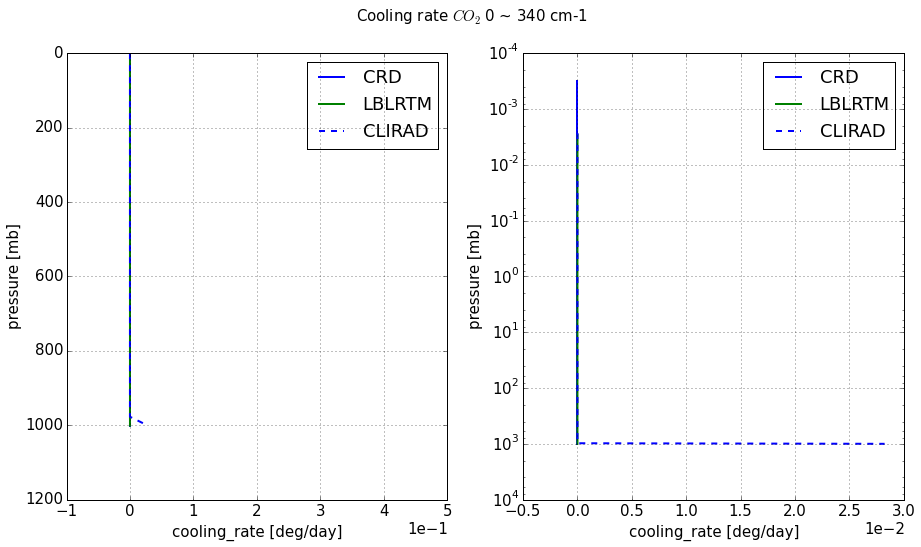

---------------------------------------------------------------------------


Wavenumber band: 2, 340 ~ 540 cm-1

CRD
       pressure   flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -82.31578   0.000004 -82.315776            -0
30   299.800000 -82.31578   0.000008 -82.315772            -0
0   1013.000000 -82.31578   0.000008 -82.315772            -0

LBLRTM
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -82.280681   0.000000 -82.280681      0.000000
30   299.800000 -82.288931   0.007236 -82.281695      0.000028
0   1013.000000 -82.315835   0.169081 -82.146753      0.003434

CLIRAD
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -82.293027   0.000000 -82.293027      0.000000
30   299.8000 -82.301149   0.006975 -82.294174      0.000023
0   1013.0000 -82.315849   0.162686 -82.153163      0.007236

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70         0 -0.035099   0.000004 -0.035095     -0

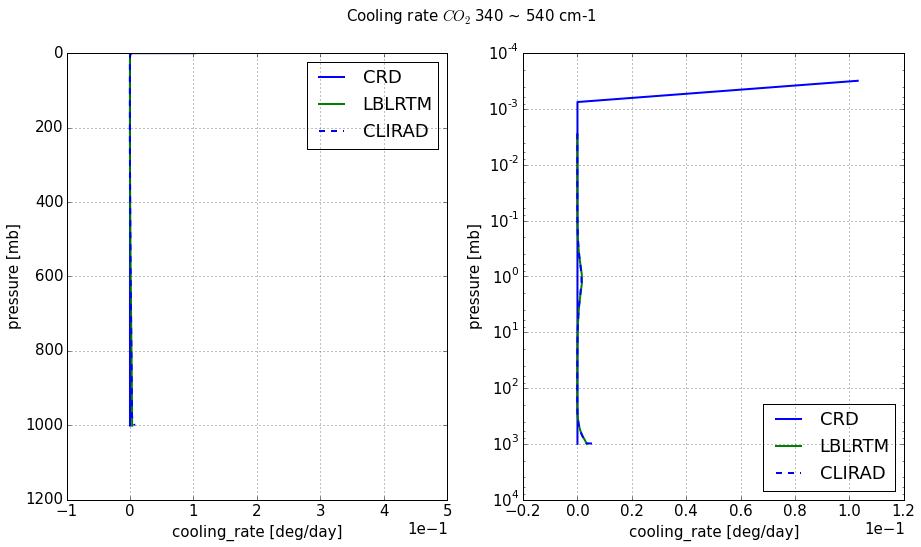

---------------------------------------------------------------------------


Wavenumber band: 3, 540 ~ 800 cm-1

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417  -75.12937   0.020004 -75.109366      7.980369
30   299.800000  -81.10612  20.856530 -60.249590      0.153453
0   1013.000000 -112.81600  73.050320 -39.765680      0.355527

LBLRTM
       pressure     flux_up  flux_down   net_flux  cooling_rate
70     0.002417  -74.188410   0.000000 -74.188410      0.000000
30   299.800000  -80.423601  21.156397 -59.267205      0.162592
0   1013.000000 -112.837813  74.354289 -38.483524      0.305978

CLIRAD
     pressure     flux_up  flux_down   net_flux  cooling_rate
70     0.0024  -74.362434   0.000000 -74.362434      0.000000
30   299.8000  -80.782419  20.959595 -59.822824      0.153147
0   1013.0000 -112.816764  73.668361 -39.148403      0.310727

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70         0 -0.940960   0.020004 -0.9

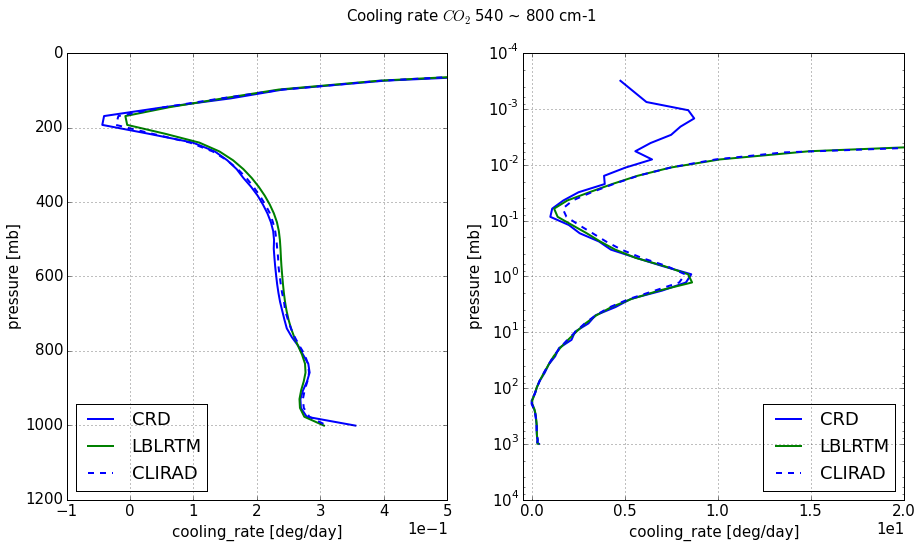

---------------------------------------------------------------------------


Wavenumber band: 4, 800 ~ 980 cm-1

CRD
       pressure   flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -61.38229   0.000000 -61.382290     -0.000000
30   299.800000 -61.43460   0.022613 -61.411987     -0.000990
0   1013.000000 -61.64932   0.834607 -60.814713      0.017742

LBLRTM
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -61.310693   0.000000 -61.310693      0.000000
30   299.800000 -61.384263   0.033894 -61.350369     -0.001403
0   1013.000000 -61.681243   1.093502 -60.587741      0.023263

CLIRAD
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -61.278278   0.000000 -61.278278      0.000000
30   299.8000 -61.349655   0.031702 -61.317953     -0.001385
0   1013.0000 -61.657526   1.042740 -60.614785      0.013108

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70         0 -0.071597   0.000000 -0.071597     -0

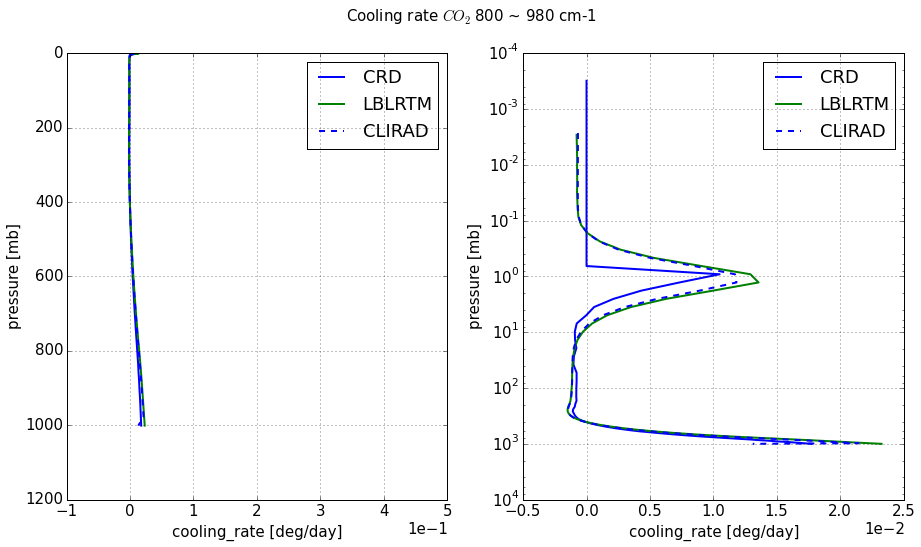

---------------------------------------------------------------------------


Wavenumber band: 5, 980 ~ 1100 cm-1

CRD
       pressure   flux_up     flux_down   net_flux  cooling_rate
70     0.002417 -31.06498  4.842877e-07 -31.064980     -0.000000
30   299.800000 -31.12266  1.873201e-02 -31.103928     -0.001379
0   1013.000000 -31.34392  7.307469e-01 -30.613173      0.016149

LBLRTM
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -30.934387   0.000000 -30.934387      0.000000
30   299.800000 -31.011912   0.029204 -30.982708     -0.001911
0   1013.000000 -31.354231   1.071269 -30.282962      0.023063

CLIRAD
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -30.919803   0.000000 -30.919803      0.000000
30   299.8000 -30.996757   0.027965 -30.968792     -0.001897
0   1013.0000 -31.337711   1.028693 -30.309018      0.017637

CRD - LBLRTM
    pressure   flux_up     flux_down  net_flux  cooling_rate
70         0 -0.130593  4.842877e-

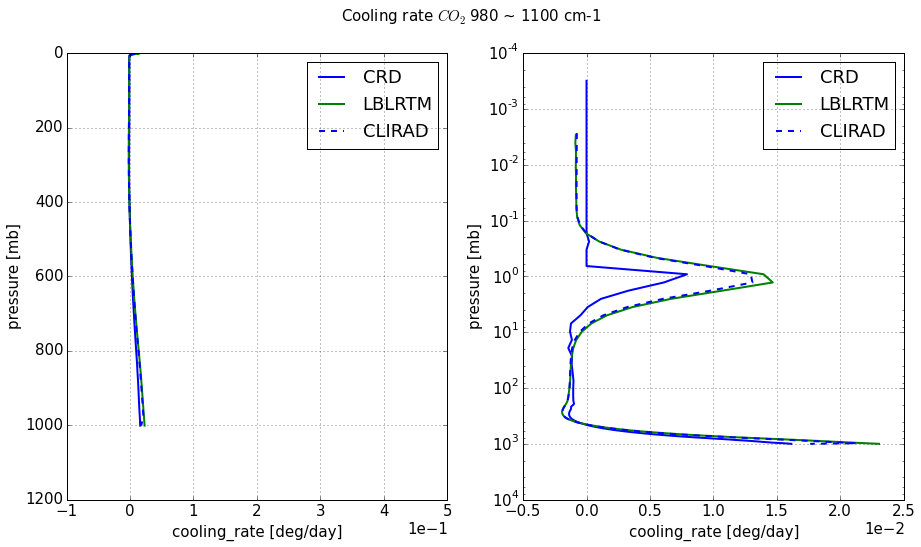

---------------------------------------------------------------------------


Wavenumber band: 6, 1100 ~ 1215 cm-1

CRD
       pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.002417 -23.27341          0 -23.27341            -0
30   299.800000 -23.27341          0 -23.27341            -0
0   1013.000000 -23.27341          0 -23.27341            -0

LBLRTM
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -23.269313   0.000000 -23.269313      0.000000
30   299.800000 -23.269348   0.000010 -23.269338     -0.000001
0   1013.000000 -23.269652   0.001256 -23.268396      0.000038

CLIRAD
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -23.245248   0.000000 -23.245248      0.000000
30   299.8000 -23.245293   0.000013 -23.245281     -0.000001
0   1013.0000 -23.254791   0.001186 -23.253605     -0.003229

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70         0 -0.004097   0.000000 -0.004097     -0.0

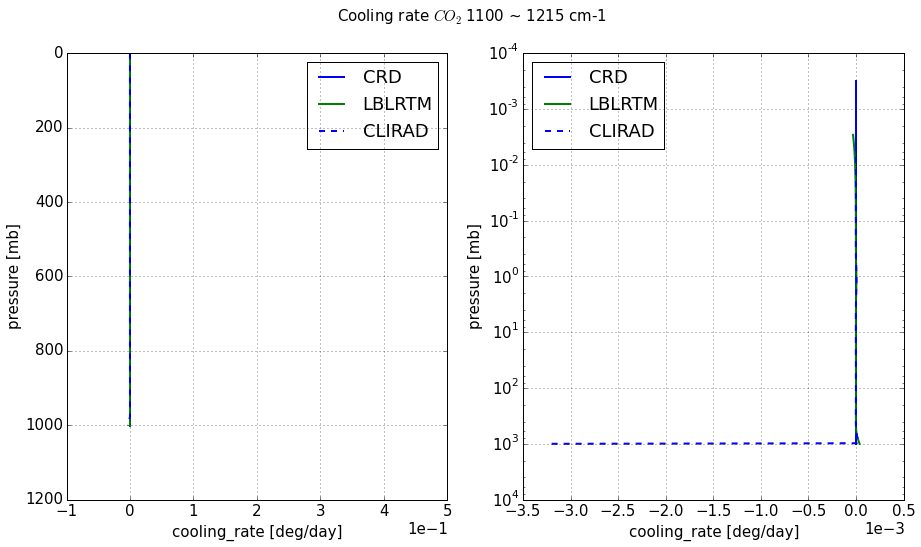

---------------------------------------------------------------------------


Wavenumber band: 7, 1215 ~ 1380 cm-1

CRD
       pressure   flux_up     flux_down   net_flux  cooling_rate
70     0.002417 -23.74062  2.458692e-07 -23.740620            -0
30   299.800000 -23.74062  1.013279e-06 -23.740619            -0
0   1013.000000 -23.74062  1.966953e-06 -23.740618            -0

LBLRTM
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -23.685410   0.000000 -23.685410      0.000000
30   299.800000 -23.719820   0.005797 -23.714023     -0.000668
0   1013.000000 -23.755165   0.067299 -23.687866      0.001106

CLIRAD
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -23.659913   0.000000 -23.659913      0.000000
30   299.8000 -23.693705   0.005602 -23.688103     -0.000648
0   1013.0000 -23.736876   0.065068 -23.671808     -0.002148

CRD - LBLRTM
    pressure   flux_up     flux_down  net_flux  cooling_rate
70         0 -0.055210  2.458692e

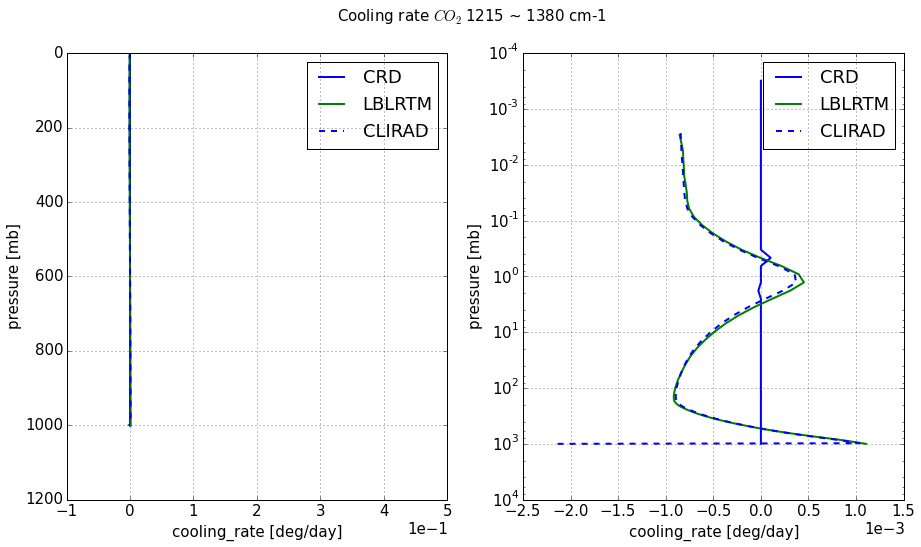

---------------------------------------------------------------------------


Wavenumber band: 8, 1380 ~ 1900 cm-1

CRD
       pressure   flux_up     flux_down   net_flux  cooling_rate
70     0.002417 -30.88047  2.421439e-07 -30.880470            -0
30   299.800000 -30.88047  1.966953e-06 -30.880468            -0
0   1013.000000 -30.88047  1.966953e-06 -30.880468            -0

LBLRTM
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -30.712876   0.000000 -30.712876      0.000000
30   299.800000 -30.719132   0.000782 -30.718350     -0.000156
0   1013.000000 -30.729595   0.017626 -30.711969      0.000368

CLIRAD
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -30.666144   0.000000 -30.666144      0.000000
30   299.8000 -30.672409   0.000765 -30.671644     -0.000155
0   1013.0000 -30.697533   0.017385 -30.680148     -0.004893

CRD - LBLRTM
    pressure   flux_up     flux_down  net_flux  cooling_rate
70         0 -0.167594  2.421439e

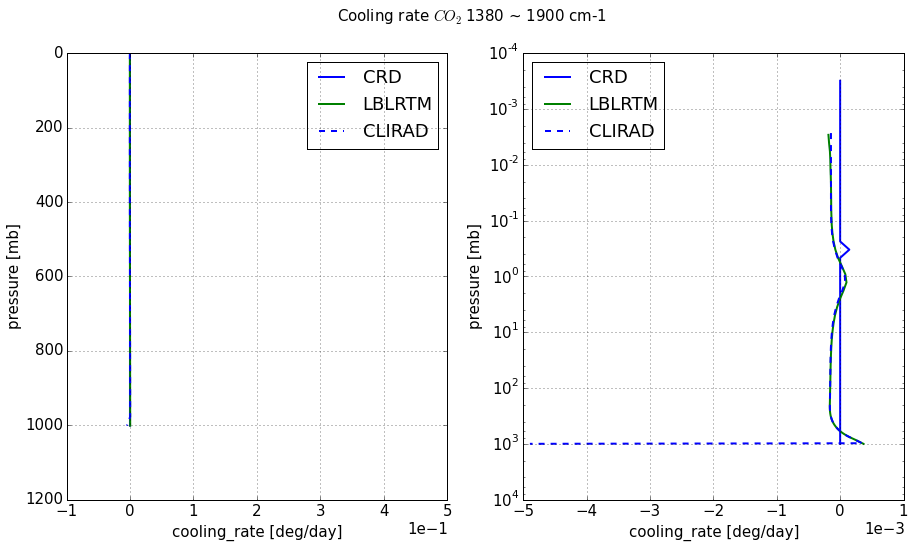

---------------------------------------------------------------------------


Wavenumber band: 9, 1900 ~ 3000 cm-1

CRD
       pressure   flux_up     flux_down  net_flux  cooling_rate
70     0.002417 -6.674494 -1.536682e-08 -6.674494            -0
30   299.800000 -6.674494 -2.533197e-07 -6.674494            -0
0   1013.000000 -6.674494 -5.066395e-07 -6.674495            -0

LBLRTM
       pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.002417 -5.798467   0.000000 -5.798467      0.000000
30   299.800000 -5.853937   0.044156 -5.809781     -0.002542
0   1013.000000 -6.625445   0.882282 -5.743164      0.007061

CLIRAD
     pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.0024 -5.495534   0.000000 -5.495534      0.000000
30   299.8000 -5.562908   0.055983 -5.506925     -0.002668
0   1013.0000 -6.614782   1.127750 -5.487032     -0.014611

CRD - LBLRTM
    pressure   flux_up     flux_down  net_flux  cooling_rate
70         0 -0.876027 -1.536682e-08 -0.876027     -0

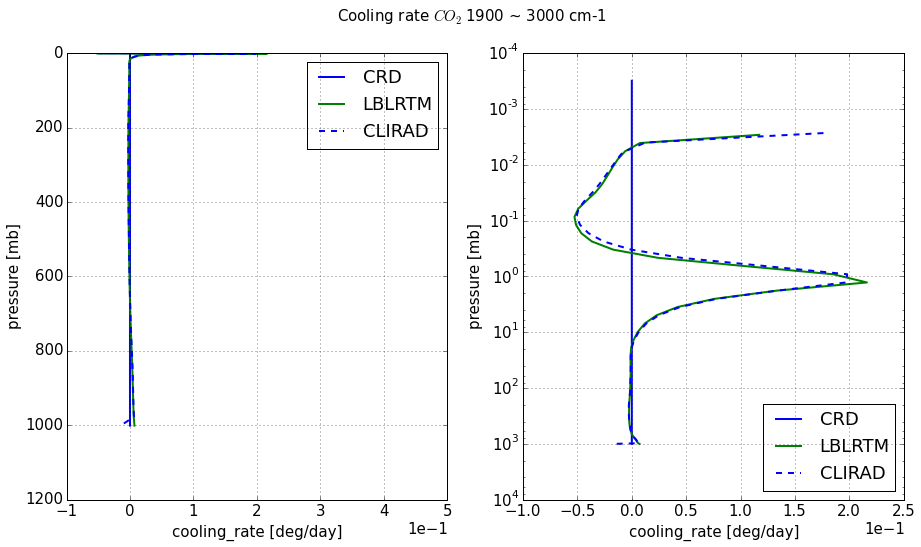

---------------------------------------------------------------------------


Wavenumber band: 10, 540 ~ 620 cm-1

CRD
       pressure       flux_up     flux_down      net_flux  cooling_rate
70     0.002417 -4.141086e-07  2.585675e-07 -1.555411e-07  3.456882e-07
30   299.800000 -2.898078e-07  3.360581e-07  4.625030e-08 -5.899863e-10
0   1013.000000 -0.000000e+00  4.719782e-07  4.719782e-07 -1.185844e-09

LBLRTM
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -29.922537   0.000000 -29.922537       0.00000
30   299.800000 -31.195592   2.531070 -28.664522       0.04107
0   1013.000000 -36.235420  16.135422 -20.099999       0.13053

CLIRAD
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -30.007802   0.000000 -30.007802      0.000000
30   299.8000 -31.291673   2.485550 -28.806123      0.038305
0   1013.0000 -36.231410  15.925742 -20.305668      0.130990

CRD - LBLRTM
    pressure    flux_up     flux_down   net_flux  cooling_rate
70  

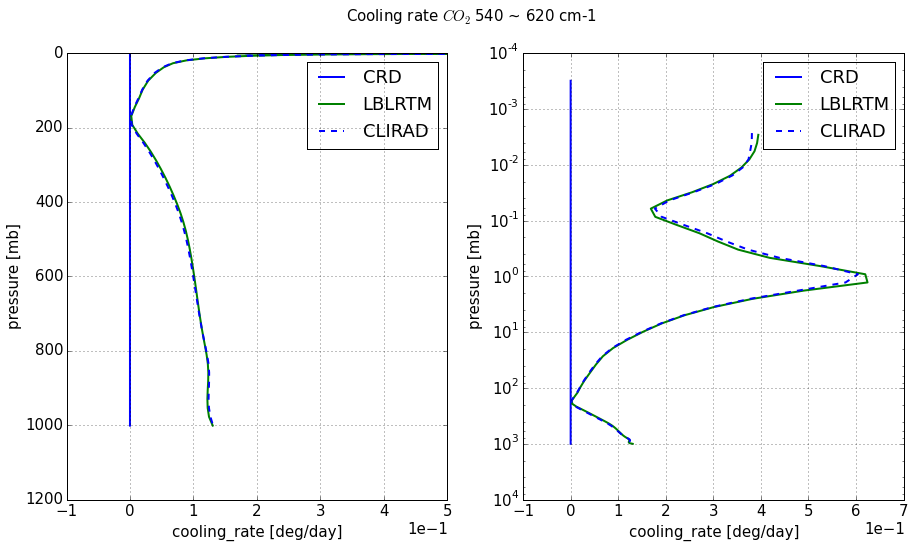

In [47]:
print('Flux tables and cooling rates in CLIRAD spectral bands')
print()
print()

fluxtableNhrplot_by_clirad_bands(pnl_clirad, \
                                ('CRD', 'b', '-', pnl_crd), \
                                ('LBLRTM', 'g', '-', pnl_lblrtm))

In [24]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')